In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess

In [2]:
# 1. Simulate trend + seasonality + noise
np.random.seed(2024)
n = 100
t = np.arange(1, n+1)
time_index = pd.date_range("2000-01-01", periods=n, freq="ME")

mu = -5 + 0.1 * t                        # 線性趨勢
ss = np.sin(2 * np.pi * t / 12)         # 每 12 期的季節性
e = 0.5 * np.random.randn(n)            # 隨機噪音
y = mu + ss + e

df = pd.DataFrame({"y": y, "signal": mu + ss}, index=time_index)

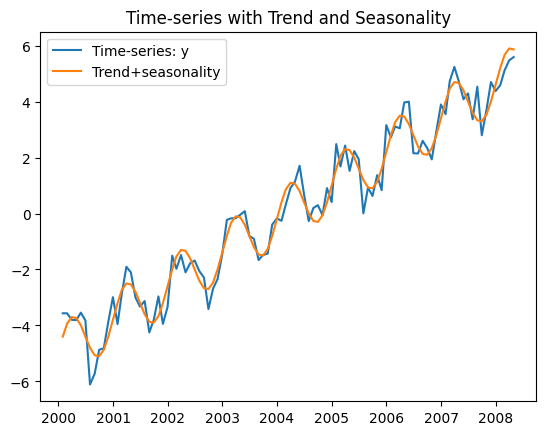

In [3]:
plt.figure()
plt.plot(df.index, df["y"], label="Time-series: y")
plt.plot(df.index, df["signal"], label="Trend+seasonality")
plt.legend()
plt.title("Time-series with Trend and Seasonality");

In [4]:
# 2. 去除趨勢與季節性：一次回歸 + 正餘弦基底
# 趨勢項
X_trend = sm.add_constant(t)
trend_mod = sm.OLS(y, X_trend).fit()
trend_fitted = trend_mod.fittedvalues

# 季節項（正餘弦雙基底）
X_season = np.column_stack([np.sin(2*np.pi*t/12), np.cos(2*np.pi*t/12)])
X_full = sm.add_constant(np.column_stack([t, X_season]))
full_mod = sm.OLS(y, X_full).fit()
residual = full_mod.resid

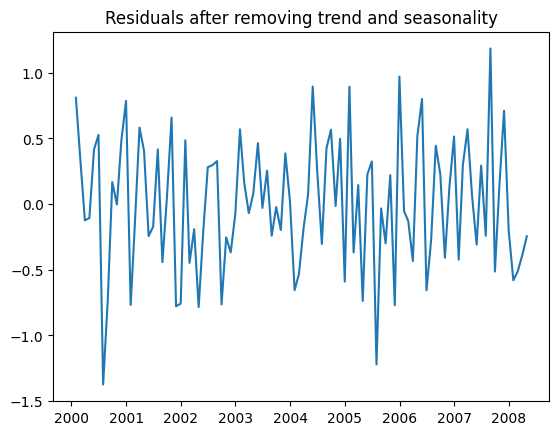

In [5]:
#"移除趨勢與季節性後的殘差
plt.figure()
plt.plot(df.index, residual)
plt.title("Residuals after removing trend and seasonality");

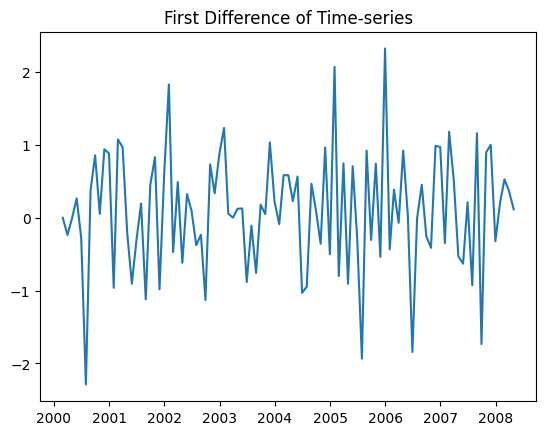

In [6]:
# 3. 一階差分示範（去除趨勢）
d1 = np.diff(y)
plt.figure()
plt.plot(time_index[1:], d1)
plt.title("First Difference of Time-series");

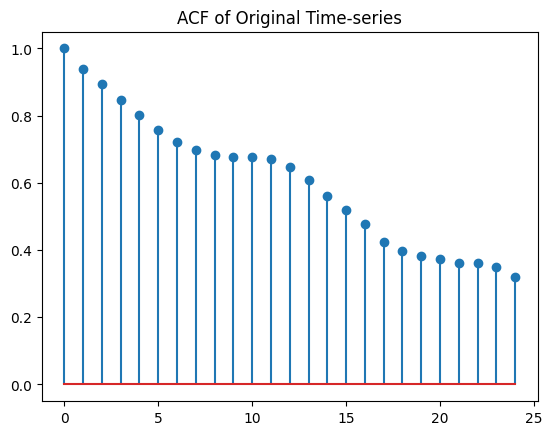

In [7]:
# 4. 模型識別：ACF
acf_orig = acf(y, nlags=24)
acf_resid = acf(residual, nlags=24)
plt.figure()
plt.stem(range(len(acf_orig)), acf_orig)
plt.title("ACF of Original Time-series");


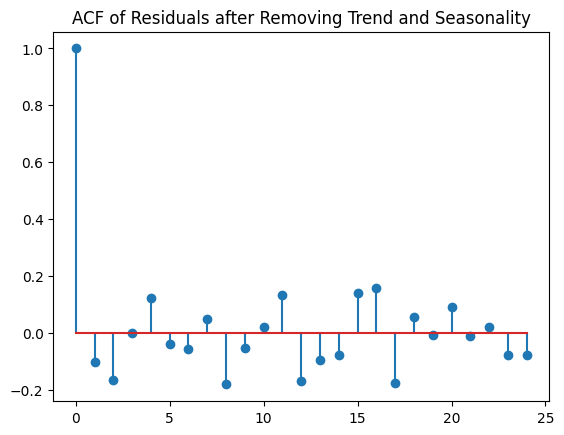

In [8]:
plt.figure()
plt.stem(range(len(acf_resid)), acf_resid)
plt.title("ACF of Residuals after Removing Trend and Seasonality");

In [16]:
# 5. AR(1) 模擬與理論 vs 樣本 ACF/PACF
phi1 = 0.8
ar1 = np.array([1, -phi1])  # AR polynomial coefficients: 1 - phi1 * B
ma1 = np.array([1])         # MA(0)
AR1 = ArmaProcess(ar1, ma1)
y1 = AR1.generate_sample(nsample=200, scale=1.0)

# 理論與樣本 ACF
theo_acf1 = AR1.acf(lags=10)
samp_acf1 = acf(y1, nlags=10)

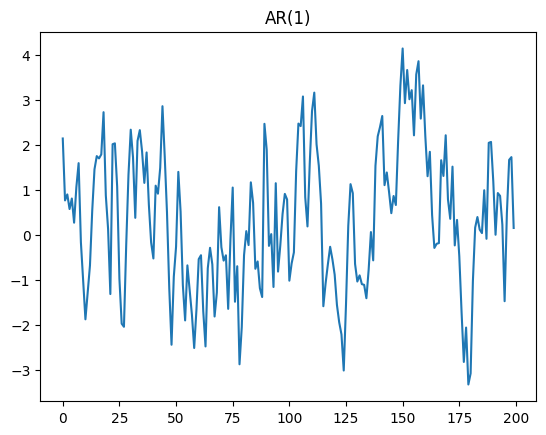

In [17]:
plt.figure()
plt.plot(y1)
plt.title("AR(1)");

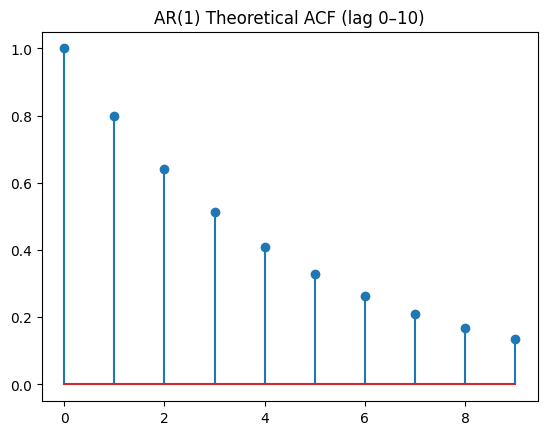

In [18]:
plt.figure()
plt.stem(range(len(theo_acf1)), theo_acf1)
plt.title("AR(1) Theoretical ACF (lag 0–10)");

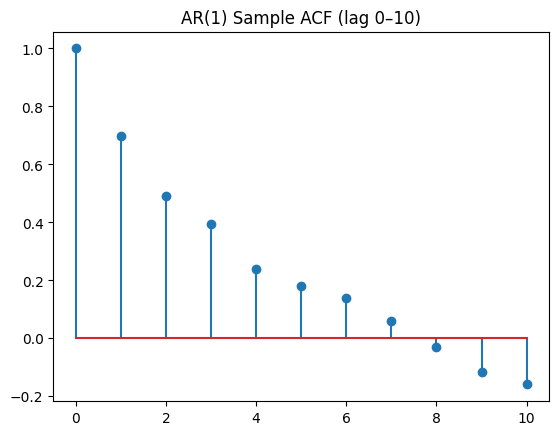

In [19]:
plt.figure()
plt.stem(range(len(sam_acf1)), sam_acf1)
plt.title("AR(1) Sample ACF (lag 0–10)");

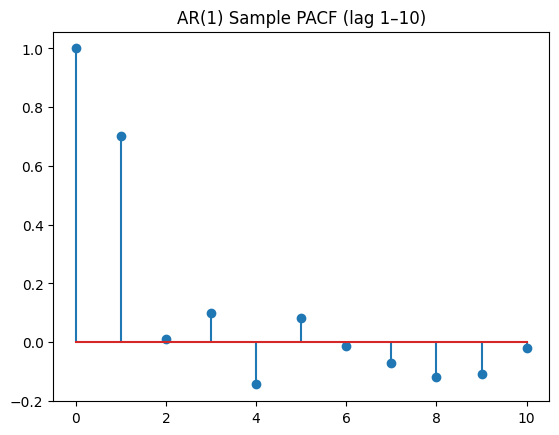

In [20]:
plt.figure()
plt.stem(range(len(sam_pacf1)), sam_pacf1)
plt.title("AR(1) Sample PACF (lag 1–10)");

In [21]:
# --- 2. AR(2) with phi1=0.3, phi2=0.4 ---
phi = np.array([0.3, 0.4])
ar2 = np.r_[1, -phi]  # [1, -phi1, -phi2]
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
y2 = AR2.generate_sample(nsample=200, scale=1.0)

theo_acf2 = AR2.acf(lags=10)
samp_acf2 = acf(y2, nlags=10)


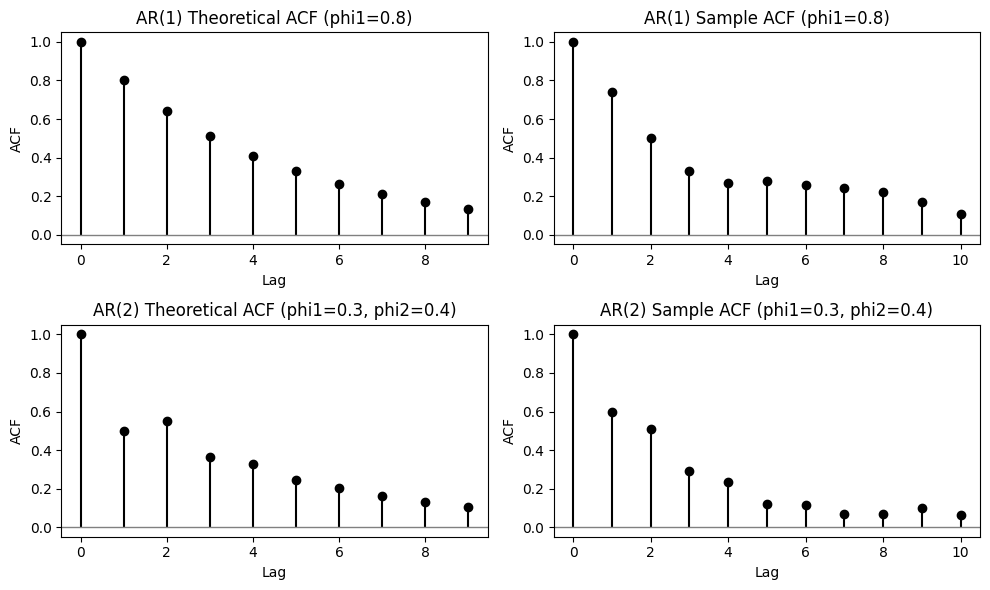

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# AR(1) ACF
axes[0,0].stem(range(len(theo_acf1)), theo_acf1, basefmt=" ", linefmt="black")
axes[0,0].set_title("AR(1) Theoretical ACF (phi1=0.8)")
axes[0,1].stem(range(len(samp_acf1)), samp_acf1, basefmt=" ", linefmt="black")
axes[0,1].set_title("AR(1) Sample ACF (phi1=0.8)")

# AR(2) ACF
axes[1,0].stem(range(len(theo_acf2)), theo_acf2, basefmt=" ", linefmt="black")
axes[1,0].set_title("AR(2) Theoretical ACF (phi1=0.3, phi2=0.4)")
axes[1,1].stem(range(len(samp_acf2)), samp_acf2, basefmt=" ", linefmt="black")
axes[1,1].set_title("AR(2) Sample ACF (phi1=0.3, phi2=0.4)")

for ax in axes.flatten():
    ax.axhline(0, color='gray', lw=1)
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")

plt.tight_layout()
plt.show()
